# [1] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

# Task to be performed:
1. read the data and preprocess it
2. consider 2k/3k reviews from the preprocessed data.
3. convert only those reviews into vectors, (BOW, TFIDF, Avg W2V, TFIDF W2V) (Please check out the Notebook we have given to know more about these methods)
4. we can skip the bigrams or n-grams.
5. and then apply TSNE() refer mnist dataset to get more insights into how to apply

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re 
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
con = sqlite3.connect("./amazon-fine-food-reviews/database.sqlite")
data = pd.read_sql_query('''
SELECT *
FROM REVIEWS
WHERE SCORE != 3''', con)
data.shape

(525814, 10)

# Data Cleaning

In [17]:
data = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]
data.shape

(525812, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [18]:
data['Score'] = data["Score"].apply(lambda x: "positive" if x > 3 else "negative")
sorted_data = data.sort_values('ProductId',axis = 0, inplace = False, kind = 'quicksort',ascending = True)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138693,150511,0006641040,A1C9K534BCI9GO,Laura Purdie Salas,0,0,positive,1344211200,Charming and childlike,"A charming, rhyming book that describes the ci..."
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,positive,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books..."
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,positive,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...


In [19]:
filtered_data = sorted_data.drop_duplicates(subset = {'UserId','ProfileName','Time'} ,keep = 'first', inplace = False)
filtered_data.shape
final = filtered_data.copy()

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\manish
[nltk_data]     dogra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stop = set(stopwords.words("english"))
st = PorterStemmer()

##  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [22]:
def cleanhtml(sent):
    cleanr = re.compile('<.*?>')
    cleaned = re.sub(cleanr,' ',sent)
    return cleaned
def cleanpunc(sent):
    clean = re.sub(r'[?|!|$|#|\'|"|:]',r'',sent)
    clean = re.sub(r'[,|(|)|.|\|/]',r' ',clean)
    return clean

In [23]:
i=0
all_positive_reviews =[]
all_negative_reviews = []
final_string = []
stem_data = " "
for p in final['Text'].values:
    filtered_sens = []#filtered word
    p = cleanhtml(p)
    for w in p.split():
       # print(w)
        punc = cleanpunc(w)
        for s in punc.split():
            #print(w)
            if (s.isalpha()) & (len(s)>2):
                if s.lower() not in stop:
                    stem_data = (st.stem(s.lower())).encode('utf8')
                    #can we use lemmatizer and stemming altogether??
                    filtered_sens.append(stem_data)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_reviews.append(stem_data)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_reviews.append(stem_data)
                else:
                    continue
            else:
                continue
    #print(filtered_sens)
    str1 = b" ".join(filtered_sens)
    #print(str1)
    final_string.append(str1)
    i+=1

In [25]:
final['cleaned_text']=final_string  
final['cleaned_text']=final['cleaned_text'].str.decode("utf-8")

In [26]:
data_pos = final[final['Score'] == 'positive'].sample(2000)
data_neg = final[final['Score'] == 'negative'].sample(2000)

In [27]:
data = pd.concat([data_pos,data_neg])
data.shape

(4000, 11)

In [28]:
data.sort_values('Time',axis= 0,inplace = True , na_position = 'last',ascending = True)

In [29]:
X = data['cleaned_text']
y = data['Score']

# TSNE on BOW

In [41]:
count_vect = CountVectorizer(ngram_range = (1,2))
bow_vect = count_vect.fit_transform(X)
bow_vect = bow_vect.todense()

In [42]:
print(len(count_vect.get_feature_names()))

117165


In [43]:
# class sklearn.manifold.TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0,
#                             n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, 
#                             metric=’euclidean’, init=’random’, verbose=0, random_state=None, 
#                             method=’barnes_hut’, angle=0.5
tsne_2d = TSNE(n_components = 2,perplexity = 30.0,learning_rate = 200.0,
              n_iter = 5000,random_state = 0,
              method = 'barnes_hut')
bow_tsne = tsne_2d.fit_transform(bow_vect)

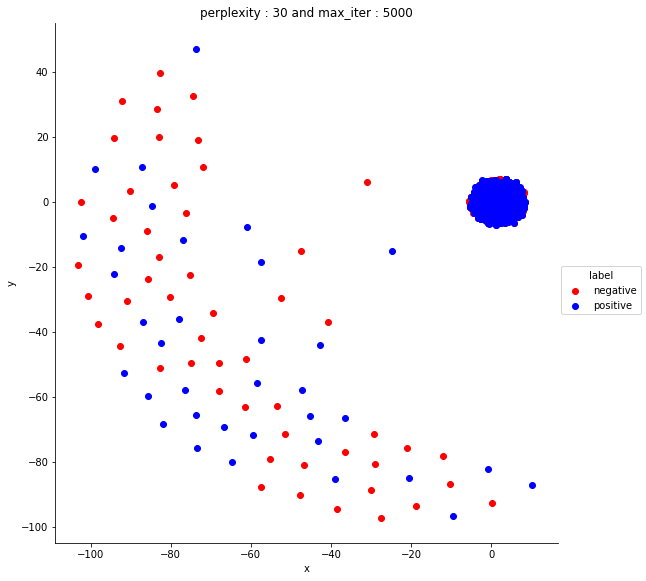

In [58]:
df_bow = pd.DataFrame({'x':bow_tsne[:,0],'y':bow_tsne[:,1],'label':y})
sns.FacetGrid(df_bow,hue = 'label',size = 8,hue_kws = {'color':['r','b']}).map(plt.scatter,'x','y').add_legend()
plt.title("perplexity : {} and max_iter : {}".format(30, 5000))
plt.show()

# Observation
* As we can see in bag of words vectorization, we cannot seperate the positive or negative labels with plane as there is a intermixing of negative and positve label.

# TSNE on Tfidf

In [59]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
X_tfidf = tfidf_vect.fit_transform(X)
sc = StandardScaler(with_mean = False)
X_tfidf =sc.fit_transform(X_tfidf)
X_tfidf = X_tfidf.todense()

In [60]:
print(len(tfidf_vect.get_feature_names()))

117165


In [61]:
tsne_2d = TSNE(n_components = 2,perplexity = 30.0,learning_rate = 200.0,
              n_iter = 5000,random_state = 0,
              method = 'barnes_hut')
tfidf_tsne = tsne_2d.fit_transform(X_tfidf)

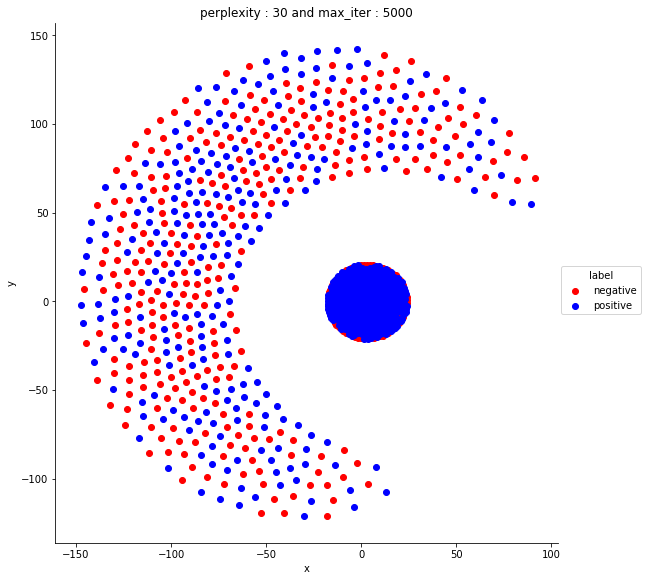

In [62]:
df_tfidf = pd.DataFrame({'x': tfidf_tsne[:,0],'y': tfidf_tsne[:,1],'label': y})
sns.FacetGrid(df_tfidf,hue = 'label',size = 8,hue_kws = {'color':['r','b']}).map(plt.scatter,'x','y').add_legend()
plt.title("perplexity : {} and max_iter : {}".format(30, 5000))
plt.show()

# Observation
* As we can see in Tfidf vectorization, also we cannot seperate the positive or negative labels with plane as there is lot  intermixing and overlapping of negative and positve label.

# TSNE on Avg-W2vec

In [64]:
list_of_sent = []
for i in X:
    sent = []
    for word in i.split():
        sent.append(word)
    list_of_sent.append(sent)

In [67]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4)
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    sent_vec /= cnt_word
    sent_vectors.append(sent_vec)
print(len(sent_vectors))

4000


In [68]:
np.where(np.isnan(sent_vectors))

(array([], dtype=int64), array([], dtype=int64))

In [69]:
sc = StandardScaler()
avg_w2v = sc.fit_transform(sent_vectors)

In [70]:
tsne_2d = TSNE(n_components = 2,perplexity = 30.0,learning_rate = 200.0,
              n_iter = 5000,random_state = 0,
              method = 'barnes_hut')
w2v_tsne = tsne_2d.fit_transform(avg_w2v)

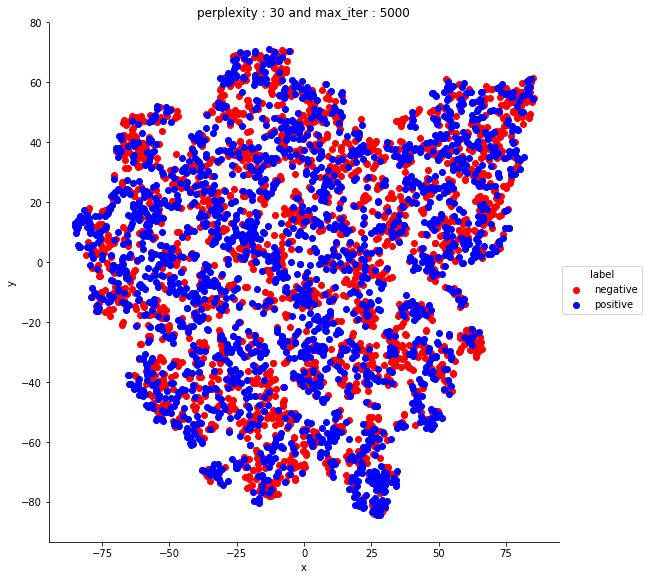

In [71]:
df_w2v = pd.DataFrame({'x': w2v_tsne[:,0],'y': w2v_tsne[:,1],'label': y})
sns.FacetGrid(df_w2v,hue = 'label',size = 8,hue_kws = {'color':['r','b']}).map(plt.scatter,'x','y').add_legend()
plt.title("perplexity : {} and max_iter : {}".format(30, 5000))
plt.show()

# Observation
* As we can see in Avg-W2vec vectorization, also we cannot seperate the positive or negative labels with plane as there is lot  intermixing and overlapping of negative and positve label.

# TSNE on Tfidf-W2vec

In [76]:
tf_idf_feat = tfidf_vect.get_feature_names()
tfidf_sent_vec = []
row = 0
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = X_tfidf[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec/= weight_sum
    tfidf_sent_vec.append(sent_vec)
    row += 1

In [77]:
np.where(np.isnan(tfidf_sent_vec))

(array([], dtype=int64), array([], dtype=int64))

In [78]:
tfidf_w2v = sc.fit_transform(tfidf_sent_vec)

In [79]:
tsne_2d = TSNE(n_components = 2,perplexity = 30.0,learning_rate = 200.0,
              n_iter = 5000,random_state = 0,
              method = 'barnes_hut')
tfw2v_tsne = tsne_2d.fit_transform(tfidf_w2v)

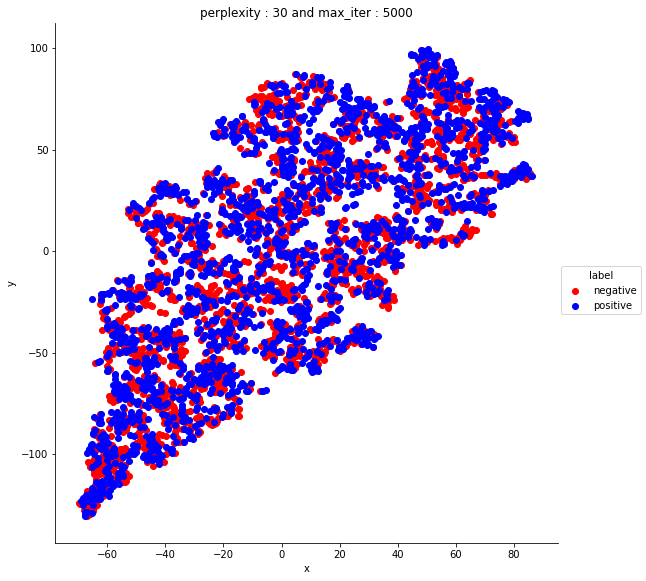

In [80]:
df_tfw2v = pd.DataFrame({'x': tfw2v_tsne[:,0],'y': tfw2v_tsne[:,1],'label': y})
sns.FacetGrid(df_tfw2v,hue = 'label',size = 8,hue_kws = {'color':['r','b']}).map(plt.scatter,'x','y').add_legend()
plt.title("perplexity : {} and max_iter : {}".format(30, 5000))
plt.show()

# Observation
* As we can also see the similar situation in Tfidf-W2vec vectorization, the plane will be not able to seperate the positive or negative labels as there is lot  intermixing and overlapping of negative and positve label.

# Conclusion
Tsne for all vectorisation techniques, we can see that the plane cannot seprate them as positive or negative lable.